In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import os
import random
import warnings

import numpy as np
import pandas as pd
import pyarrow.feather as ft
import catboost as cb
from datetime import datetime, timedelta

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from catboost_utils import MedianAPE

from tqdm import tqdm

from base_price import BasePrice, DoubleRegression

from matplotlib import pyplot as plt

warnings.simplefilter('ignore')
np.random.seed(10)

In [3]:
from scipy.stats import gmean, hmean

In [4]:
PATH = '../data'

TRAIN_DATA = 'project_train.f'
TEST_DATA = 'project_test_public.f'
OPTION = 'option_names.csv'

TRAIN_PATH = os.path.join(PATH, TRAIN_DATA)
TEST_PATH = os.path.join(PATH, TEST_DATA)
OPTION_PATH = os.path.join(PATH, OPTION)

data = ft.read_feather(TRAIN_PATH)
options = pd.read_csv(OPTION_PATH, index_col='id')
data.shape

(1424484, 70)

In [16]:
data.groupby(['brand', 'model'])['generation'].agg(lambda x: np.unique([i.split(' ')[-1] for i in x])).sample(50)

brand          model           
Toyota         Corolla Fielder     [(2000—2004), (2003—2007), (2006—2012), (2008—...
ИЖ             2715                                                      (1972—2001)
SsangYong      Rodius                                                    (2007—2013)
ВАЗ (LADA)     2102                                                      (1971—1986)
Mazda          Atenza                                                    (2002—2008)
Geely          Emgrand EC7                                               (2009—2016)
Infiniti       FX30                                                      (2011—2013)
Mercedes-Benz  GLA-класс                                  [(2013—2017), (2017—2020)]
Mitsubishi     Pajero Pinin                                              (1998—2006)
Cadillac       SRX                                        [(2009—2012), (2012—2016)]
Subaru         Domingo                                                   (1983—1994)
JAC            S3                

In [5]:
mask = data.brand.eq('Mitsubishi') & data.model.eq('Lancer') & data.equipment.eq('Базовая') & data.generation.eq('X (2007—2010)') & data.year.eq(2008) & data.modification.eq('1.8 CVT (143 л.с.)')

In [6]:
my_vals = data[mask].actual_price.values

In [7]:
data['price'] = pd.to_numeric(data['price'])

In [8]:
data.description.sample(10)

1332864    Компания “МОТОР ЛЕНД” имеет успешный опыт прод...
1026478    Новое поступление в Автосалон CAR CITY! Рады в...
1051048    Машина в очень хорошем состоянии,мотор работае...
1314218    Присутствуют сколы и мелкие царапины! Крашены ...
1237557    Авто для своих лет, сохранилось хорошо.\nВсе с...
33567      На отличном бодром ходу , доедет куда угодно в...
1153886                          Машина в отличном состоянии
224451     Абсолютно новый автомобиль! \n Двухцветный кож...
66344      Отличное состояние. Я владелец, оформлен на же...
1258448    На ходу. Заводиться передвигается ,за месяц до...
Name: description, dtype: object

In [9]:
bm = data[['brand', 'model']].drop_duplicates().groupby('model').agg(['count', lambda x: x.unique()])
mask = bm.loc[:, ('brand', 'count')] > 1

bm[mask]

brand                            
         count                  <lambda_0>
model                                     
2110         2        [Богдан, ВАЗ (LADA)]
Bongo        2                [Kia, Mazda]
Corsa        2              [Toyota, Opel]
Gentra       2             [Daewoo, Ravon]
Matrix       2           [Toyota, Hyundai]
Nexia        3  [Chevrolet, Ravon, Daewoo]
Niva         2     [Chevrolet, ВАЗ (LADA)]
Sprinter     2     [Mercedes-Benz, Toyota]
V5           2           [FAW, Brilliance]

In [10]:
data[data.model.eq('Bongo')].groupby('brand').year.min()

brand
Kia      2004
Mazda    1983
Name: year, dtype: int64

In [11]:
data_advert = data[data.actual_price.isna()]
data_dealer = data[data.actual_price.notna()]

In [12]:
data_dealer.shape

(81426, 70)

In [13]:
data_advert

,actual_price,price,start_date,close_date,sale_end_date,brand,model,generation,modification,equipment,...,electroprivod_mult,fary_mult,multimedia_navigacia_mult,obogrev_mult,pamyat_nastroek_mult,podushki_bezopasnosti_mult,pomosh_pri_vozhdenii_mult,protivoygonnaya_sistema_mult,salon_mult,upravlenie_klimatom_mult
0,NaN,1950000.0,2023-02-18 13:37:49.603445,2023-02-19 15:06:28.603039,NaT,Volkswagen,Passat,B8 (2014—2020),2.0 TDI DSG (150 л.с.),Highline,...,[13729],"[13783,13784]","[13763,13764,13765,13766,13767,13768,13769,137...","[13721,13722,13723,13724]",None,"[13751,13752,13753,13754,13755]","[13739,13740,13741,13742,13744,13745,13746]","[13747,13748,13749]",[13719],[13713]
1,NaN,1999000.0,2023-02-11 19:49:43.158681,2023-02-24 11:04:43.685727,NaT,Volkswagen,Passat,B8 (2014—2020),2.0 TDI DSG (150 л.с.),Highline,...,"[13729,13733]","[13783,13784,13785]","[13763,13764,13765,13767,13768,13769,13770,137...","[13721,13723,13724]",None,"[13751,13753,13754,13755]","[13739,13740,13741,13742,13744,13745,13746]","[13748,13749]",[13719],"[13712,13713]"
2,NaN,1780000.0,2023-02-04 14:39:08.813905,2023-02-24 20:48:25.210683,NaT,Volkswagen,Passat,B8 (2014—2020),2.0 TDI DSG (150 л.с.),None,...,"[13729,13731,13733]",[13783],"[13768,13772]",None,None,"[13751,13752,13753,13754]","[13740,13741,13742,13744,13745,13746]",[13749],None,None
3,NaN,1900000.0,2023-02-04 08:04:20.229815,2023-02-15 17:20:49.248078,NaT,Volkswagen,Passat,B8 (2014—2020),2.0 TDI DSG (150 л.с.),Highline,...,"[13729,13731,13733]","[13783,13784,13785]","[13763,13764,13765,13768,13769,13770,13771,13772]","[13721,13723,13724]",None,"[13751,13752,13753,13754,13755]","[13739,13740,13741,13742,13743,13744,13745,13746]","[13747,13749]",[13719],"[13712,13713]"
4,NaN,1650000.0,2023-02-04 01:42:29.723361,2023-02-04 12:26:13.572696,NaT,Volkswagen,Passat,B8 (2014—2020),2.0 TDI DSG (150 л.с.),Conceptline,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424479,NaN,440000.0,2022-03-12 18:26:29.843707,2022-03-13 17:57:18.947006,NaT,Toyota,Ipsum,M10 (1995—2001),2.0 4WD AT (135 л.с.),Базовая,...,"[13731,13733]",None,"[13764,13765,13770,13771]",[13724],None,[13751],None,[13748],None,None
1424480,NaN,385000.0,2022-03-09 06:13:27.888078,2022-03-09 16:02:01.600249,NaT,Toyota,Ipsum,M10 (1995—2001),2.0 4WD AT (135 л.с.),Базовая,...,None,None,None,None,None,None,None,None,None,None
1424481,NaN,485000.0,2022-03-06 17:47:12.636290,2022-03-16 17:16:43.982866,NaT,Toyota,Ipsum,M10 (1995—2001),2.0 4WD AT (135 л.с.),Базовая,...,None,None,None,None,None,None,None,None,None,None
1424482,NaN,477000.0,2022-03-05 15:23:52.626344,2022-04-01 09:33:01.959260,NaT,Toyota,Ipsum,M10 (1995—2001),2.0 4WD AT (135 л.с.),Базовая,...,None,None,None,None,None,None,None,None,None,None


779358 919956 799565 94251 1114799

In [14]:
data_dealer = data[data['actual_price'].notna()].drop(labels=['start_date', 'close_date'], axis=1)
data_advert = data[data['actual_price'].isna()].drop(labels=['sale_end_date', 'actual_price', 'crashes', 'is_taxi', 'is_carsharing'], axis=1)

data_dealer['sale_end_date'] = pd.to_datetime(data_dealer['sale_end_date'])
data_advert['start_date'] = pd.to_datetime(data_advert['start_date'])
data_advert['close_date'] = pd.to_datetime(data_advert['close_date'])
data_advert['selling_time'] = (data_advert['close_date'] - data_advert['start_date']).dt.days

data_dealer.shape, data_advert.shape

((81426, 68), (1343058, 66))

In [15]:
data.groupby(['brand']).model.count().le(13).sum()

1

In [16]:
def get_metric(y_true, y_pred):
    bias = pd.Series((y_true - y_pred) / y_true * 100, name='bias')
    stats = pd.concat([
        bias.describe(),
        bias.abs().describe(),
    ], axis=1)
    stats.columns = ['bias', 'MAPE']

    return stats

def style_median_ape(df):
    color = 'background-color: lightgreen'
    df_style = pd.DataFrame('', index=df.index, columns=df.columns)
    df_style.loc['50%', 'MAPE'] = color
    return df_style

def show_top_errors(df, y_pred, top_k=10):
    x = df.copy()
    x['base_price'] = y_pred
    x['bias'] = (x['actual_price'] - y_pred) / x['actual_price'] * 100
    x['ape'] = np.abs(x['bias'])
    idx = np.argpartition(x['ape'].values, len(x['ape'].values) - top_k)[-top_k:]
    x = x[['bias', 'base_price', 'actual_price', 'price', 'sale_end_date', 'brand', 'model', 'generation', 'modification', 'year']]
    return x.iloc[idx]

In [17]:
# data_dealer.to_csv('data_dealer.csv', index=False)
# data_advert.to_csv('data_advert.csv', index=False)

In [18]:
data_advert['selling_time'] = data_advert['selling_time'].apply(lambda x: 0 if x < 0 else x)

In [19]:
selling_time_counts = data_advert['selling_time'].value_counts().sort_index()
selling_time_counts[(selling_time_counts.index > 7) & (selling_time_counts.index < 90)].sum()

744465

In [20]:
data_advert.brand.unique()
(~data_advert.brand.isin(data_dealer.brand.unique())).sum()

1203

In [21]:
# pd.Series(boxcox(data_advert.selling_time)[0]).plot.hist(bins=20)

<AxesSubplot:ylabel='Frequency'>

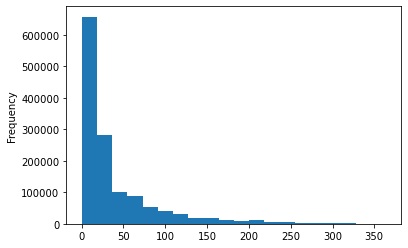

In [22]:
data_advert.selling_time.plot.hist(bins=20)

<AxesSubplot:ylabel='Frequency'>

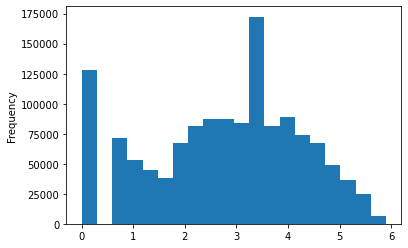

In [23]:
data_advert.selling_time.apply(np.log1p).plot.hist(bins=20)

In [24]:
data_advert.selling_time.apply(np.log1p).describe()

count    1.343058e+06
mean     2.775878e+00
std      1.491634e+00
min      0.000000e+00
25%      1.791759e+00
50%      2.995732e+00
75%      3.891820e+00
max      5.899897e+00
Name: selling_time, dtype: float64

In [25]:
data_advert = data_advert[(data_advert.selling_time > 7) & (data_advert.selling_time < 90)]

(data_advert.selling_time == 30) & (data_advert.selling_time == 60)

In [27]:
last_n_days = 30
last_date = data_dealer['sale_end_date'].max()
train = data_dealer[data_dealer['sale_end_date'] <= last_date - 2 * timedelta(last_n_days)]
val = data_dealer[(data_dealer['sale_end_date'] > last_date - 2 * timedelta(last_n_days)) & (data_dealer['sale_end_date'] <= last_date - timedelta(last_n_days))]
delayed_test = data_dealer[data_dealer['sale_end_date'] > last_date - timedelta(last_n_days)]

print(f'Train rows: {train.shape[0]}')
print(f'Min train date: {train.sale_end_date.min()}')
print(f'Max train date: {train.sale_end_date.max()}')
print(f'Val rows: {val.shape[0]}')
print(f'Min val date: {val.sale_end_date.min()}')
print(f'Max val date: {val.sale_end_date.max()}')

Train rows: 58301
Min train date: 2022-06-11 00:00:00
Max train date: 2022-12-07 00:00:00
Val rows: 11508
Min val date: 2022-12-08 00:00:00
Max val date: 2023-01-06 00:00:00


In [28]:
# grouper = BasePrice(['brand', 'model', 'year']) # avg price per week/month, использовать цены за последние 3 месяца
# grouper.fit(data)
# y_pred = grouper.predict(val)
# get_metric(val['actual_price'].values, y_pred).style.apply(style_median_ape, axis=None)

,bias,MAPE
count,11508.000000,11508.000000
mean,-4.748077,12.847611
std,27.252378,24.498221
min,-2211.265556,0.000000
25%,-12.969104,4.174493
50%,-2.065572,9.419479
75%,6.639017,17.098519
max,46.547573,2211.265556


In [29]:
train.groupby(['brand', 'model'])['actual_price'].count().index.values.shape

(557,)

In [31]:
# show_top_errors(val, y_pred, top_k=100)

,bias,base_price,actual_price,price,sale_end_date,brand,model,generation,modification,year
726266,-62.272727,5.355000e+05,330000.0,330000.0,2022-12-24,Volvo,XC70,I рестайлинг (2004—2007),2.5 4WD AT (210 л.с.),2005
94887,-62.649006,1.951788e+06,1200000.0,1400000.0,2022-12-13,Skoda,Octavia,III рестайлинг (2017—2020),1.4 TSI DSG (150 л.с.),2020
500514,-62.651224,5.188574e+05,319000.0,510000.0,2022-12-19,Skoda,Fabia,II рестайлинг (2010—2014),1.4 MT (86 л.с.),2011
516497,-62.651224,5.188574e+05,319000.0,329000.0,2022-12-19,Skoda,Fabia,II рестайлинг (2010—2014),1.4 MT (86 л.с.),2011
1159780,-63.183894,1.378904e+06,845000.0,795000.0,2022-12-25,Audi,A3,8V (2012—2016),1.4 TFSI S tronic (125 л.с.),2016
...,...,...,...,...,...,...,...,...,...,...
1121895,-76.366867,4.409172e+05,250000.0,259000.0,2022-12-19,Hyundai,Elantra,III рестайлинг (2003—2010),1.6 MT (105 л.с.) ТагАЗ,2008
1255772,-125.025485,4.252982e+05,189000.0,249000.0,2022-12-23,Volkswagen,Touran,I рестайлинг (2006—2010),1.4 TSI MT (140 л.с.),2007
349488,-93.622803,6.234654e+05,322000.0,387000.0,2022-12-14,Kia,Picanto,II (2011—2015),1.0 MT (69 л.с.),2012
582927,-66.937623,5.091598e+05,305000.0,542000.0,2022-12-31,Nissan,Note,E11 рестайлинг (2008—2013),1.4 MT (88 л.с.),2010


In [32]:
last_n_days = 30
last_date = data_dealer['sale_end_date'].max()
train = data_dealer[data_dealer['sale_end_date'] <= last_date - 2 * timedelta(last_n_days)]
val = data_dealer[(data_dealer['sale_end_date'] > last_date - 2 * timedelta(last_n_days)) & (data_dealer['sale_end_date'] <= last_date - timedelta(last_n_days))]
delayed_test = data_dealer[data_dealer['sale_end_date'] > last_date - timedelta(last_n_days)]

print(f'Train rows: {train.shape[0]}')
print(f'Min train date: {train.sale_end_date.min()}')
print(f'Max train date: {train.sale_end_date.max()}')
print(f'Val rows: {val.shape[0]}')
print(f'Min val date: {val.sale_end_date.min()}')
print(f'Max val date: {val.sale_end_date.max()}')

Train rows: 58301
Min train date: 2022-06-11 00:00:00
Max train date: 2022-12-07 00:00:00
Val rows: 11508
Min val date: 2022-12-08 00:00:00
Max val date: 2023-01-06 00:00:00


Определим категориальные и численные признаки, которые будем использовать в обучении. Заполним пропущенные значения в категориальных признаках пустой строкой.

In [33]:
cat_features = [
    'brand',
    'model',
    'generation',
    'modification',
    'color',
    'body_type',
    'equipment',
    'owners_count',
]

num_features = [
    'year',
    'mileage',
    'latitude',
    'longitude',
    'crashes',
    'is_taxi',
    'is_carsharing'
]

train[cat_features] = train[cat_features].fillna('')
val[cat_features] = val[cat_features].fillna('')

features = cat_features + num_features

X_train = train[features].reset_index(drop=True)
X_val = val[features].reset_index(drop=True)

y_train, y_val = train['actual_price'], val['actual_price']

Обучим CatBoostRegressor.

In [34]:
f = lambda x: x
inv_f = lambda x: x

transformation = "CoxBox"

if transformation == "Log":
    fy_train = np.log(y_train)
    fy_val = np.log(y_val)
    f = np.log
    inv_f = np.exp
elif transformation == "CoxBox":
    fy_train, fitted_lambda = boxcox(y_train, lmbda=None)
    fy_val = boxcox(y_val, lmbda=fitted_lambda)
    f = lambda x: boxcox(x, lmbda=fitted_lambda)
    inv_f = lambda x: inv_boxcox(x, fitted_lambda)

In [35]:
np.random.seed(10)

params = dict(
    iterations=3800,
    colsample_bylevel=0.6621004943397027,
    depth=10,
    # max_bin=80,
    boosting_type='Plain',
    bootstrap_type='MVS',
    l2_leaf_reg=1.3946357860687908e-08,
    loss_function='MAE', # 'MAE'
    use_best_model=True,
    verbose=False,
    eval_metric=MedianAPE(f, inv_f),
    random_seed=42,
    # od_pval=1.0
)
model = cb.CatBoostRegressor(
    **params,
)

eval_set = cb.Pool(data=X_val, label=f(y_val), cat_features=cat_features)
model.fit(X_train, f(y_train), cat_features=cat_features, eval_set=eval_set, plot=True, use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [36]:
model.tree_count_

3302

Посмотрим на метрики качества обученной модели. Видим, что medianAPE = 0.077510, а медиана сдвига (bias) = -0.022562.

Trial 28 finished with value: 6.992675313018867 and parameters: {'objective': 'RMSE', 'colsample_bylevel': 0.6621004943397027, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1.3946357860687908e-08, 'scaler': 0.9731799882485812}. Best is trial 28 with value: 6.992675313018867.

Best trial:
  Value: 7.21762707424735
  Params: 
    transformation: CoxBox
    objective: RMSE
    colsample_bylevel: 0.8818314784765143
    boosting_type: Plain
    depth: 10
    bootstrap_type: MVS
    l2_leaf_reg: 0.000301993341816763
    random_strength: 1.9105407452994366e-05

Best trial:
  Value: 7.221685017975302
  Params:
    boosting_type: Plain
    depth: 11
    bootstrap_type: MVS
    l2_leaf_reg: 0.6000809754492009
    random_strength: 7.901784842108324e-06

In [37]:
model.get_all_params()['learning_rate']

0.029999999329447743

In [38]:
model.best_iteration_

3301

In [39]:
val['prediction'] = inv_f(model.predict(X_val))
val['bias'] = (val['actual_price'] - val['prediction']) / val['actual_price'] * 100

stats = pd.concat([
    val.bias.describe(),
    val.bias.abs().describe(),
], axis=1)
stats.columns = ['bias', 'MAPE']

stats.style.apply(style_median_ape, axis=None)

,bias,MAPE
count,11508.000000,11508.000000
mean,-3.823809,10.982418
std,26.460244,24.375055
min,-1990.943695,0.000485
25%,-9.736990,3.337430
50%,-1.553441,7.290902
75%,5.316231,13.683473
max,87.845785,1990.943695


In [40]:
best = float('inf')
best_ratio = 0
best_bias = 0
biases = [0, 1000, -1000, 5000, -5000, 20000, -20000]
for ratio in np.linspace(0.7, 1.3, num=1000):
    for bias in biases:
        temp = np.median((val['actual_price'] - (val['prediction']*ratio + bias)).abs() / val['actual_price'])
        if temp < best:
            best = temp
            best_ratio = ratio
            best_bias = bias
print(best * 100, best_ratio, best_bias)

7.226244836904875 0.9684684684684685 20000


In [41]:
val['prediction'] = inv_f(model.predict(X_val))
val['bias'] = (val['actual_price'] - val['prediction']*best_ratio - best_bias) / val['actual_price'] * 100

stats = pd.concat([
    val.bias.describe(),
    val.bias.abs().describe(),
], axis=1)
stats.columns = ['bias', 'MAPE']

stats.style.apply(style_median_ape, axis=None)

,bias,MAPE
count,11508.000000,11508.000000
mean,-2.573758,10.886111
std,27.069852,24.917543
min,-1961.376674,0.001034
25%,-8.014345,3.383784
50%,0.021900,7.226245
75%,6.658249,13.171169
max,87.573289,1961.376674


Посмотрим на важность признаков для модели.

Сделаем предсказание на test и сохраним solution.csv.

In [42]:
val['prediction_dealer'] = inv_f(model.predict(val[model.feature_names_]))

In [49]:
delayed_test[cat_features] = delayed_test[cat_features].fillna('')

In [50]:
preds = inv_f(model.predict(delayed_test[model.feature_names_]))
get_metric(delayed_test['actual_price'].values, preds).style.apply(style_median_ape, axis=None)

,bias,MAPE
count,11617.000000,11617.000000
mean,-1.275881,10.055857
std,17.741549,14.671797
min,-693.273092,0.000260
25%,-7.286902,3.375319
50%,0.353443,7.126587
75%,7.031606,12.848802
max,68.680954,693.273092


+0.12%

In [55]:
import gc
from collections import defaultdict

data_advert = None

gc.collect()

815

In [ ]:
params = dict(
    iterations=3800,
    colsample_bylevel=0.6621004943397027,
    depth=10,
    # max_bin=80,
    boosting_type='Plain',
    bootstrap_type='MVS',
    l2_leaf_reg=1.3946357860687908e-08,
    loss_function='MAE', # 'MAE'
    use_best_model=True,
    verbose=False,
    eval_metric=MedianAPE(f, inv_f),
    random_seed=42,
    # od_pval=1.0
)

In [80]:
start_p=10
end_p=90

[f'Quantile:alpha=0.{i}' for i in list(range(start_p, end_p - 49, step_p)) + list(range(start_p + 50, end_p + 1, step_p))]

['Quantile:alpha=0.10',
 'Quantile:alpha=0.12',
 'Quantile:alpha=0.14',
 'Quantile:alpha=0.16',
 'Quantile:alpha=0.18',
 'Quantile:alpha=0.20',
 'Quantile:alpha=0.22',
 'Quantile:alpha=0.24',
 'Quantile:alpha=0.26',
 'Quantile:alpha=0.28',
 'Quantile:alpha=0.30',
 'Quantile:alpha=0.32',
 'Quantile:alpha=0.34',
 'Quantile:alpha=0.36',
 'Quantile:alpha=0.38',
 'Quantile:alpha=0.40',
 'Quantile:alpha=0.60',
 'Quantile:alpha=0.62',
 'Quantile:alpha=0.64',
 'Quantile:alpha=0.66',
 'Quantile:alpha=0.68',
 'Quantile:alpha=0.70',
 'Quantile:alpha=0.72',
 'Quantile:alpha=0.74',
 'Quantile:alpha=0.76',
 'Quantile:alpha=0.78',
 'Quantile:alpha=0.80',
 'Quantile:alpha=0.82',
 'Quantile:alpha=0.84',
 'Quantile:alpha=0.86',
 'Quantile:alpha=0.88',
 'Quantile:alpha=0.90']

In [ ]:
def calibrate_percentiles(params, start_p=10, end_p=90, step_p=5):
    quantile_metrics = [f'Quantile:alpha=0.{i}' for i in list(range(start_p, end_p - 49, step_p)) + list(range(start_p + 50, end_p + 1, step_p))]
    print(quantile_metrics)

    dict_models = dict()
    for q in quantile_metrics:
        params['loss_function'] = q
        dict_models.setdefault(q, cb.CatBoostRegressor(**params))
        dict_models[q].fit(X_train, y_train, cat_features=cat_features, eval_set=eval_set, plot=False, use_best_model=True)


    print('all models fitted')

    final_result = []

    for q in quantile_metrics:
        _feature_names = dict_models[q].feature_names_
        _temp = inv_f(dict_models[q].predict(delayed_test[_feature_names]))
        final_result.append(_temp)

    q_preds = np.stack(final_result, axis=-1)
    print('full predict shape:', q_preds.shape)

    def find_optimal(x):
        n = len(x) // 2
        optimal_k = np.array([x[idx + n] / x[idx] for idx in range(n)]).argmin()
        res = hmean([x[optimal_k], x[optimal_k + n]])
        return res

    final_preds = np.apply_along_axis(find_optimal, 1, q_preds)

    print('final predict shape:', final_preds.shape)

    return dict_models, q_preds, final_preds

dict_models, q_preds, final_preds = calibrate_percentiles(params)

In [57]:
quantile_metrics = [f'Quantile:alpha=0.{i}' for i in list(range(10, 41, 5)) + list(range(60, 91, 5))]
print(quantile_metrics)

dict_models = dict()

for q in quantile_metrics:
    params['loss_function'] = q
    dict_models.setdefault(q, cb.CatBoostRegressor(**params))
    dict_models[q].fit(X_train, f(y_train), cat_features=cat_features, eval_set=eval_set, plot=False, use_best_model=True)

['Quantile:alpha=0.10', 'Quantile:alpha=0.15', 'Quantile:alpha=0.20', 'Quantile:alpha=0.25', 'Quantile:alpha=0.30', 'Quantile:alpha=0.35', 'Quantile:alpha=0.40', 'Quantile:alpha=0.60', 'Quantile:alpha=0.65', 'Quantile:alpha=0.70', 'Quantile:alpha=0.75', 'Quantile:alpha=0.80', 'Quantile:alpha=0.85', 'Quantile:alpha=0.90']


In [59]:
final_result = []

for q in quantile_metrics:
    _feature_names = dict_models[q].feature_names_
    _temp = inv_f(dict_models[q].predict(delayed_test[_feature_names]))
    final_result.append(_temp)

q_preds = np.stack(final_result, axis=-1)

In [60]:
q_preds.shape

(11617, 14)

In [61]:
def find_optimal(x):
    n = len(x) // 2
    optimal_k = np.array([x[idx + n] / x[idx] for idx in range(n)]).argmin()
    res = hmean([x[optimal_k], x[optimal_k + n]])
    return res

final_preds = np.apply_along_axis(find_optimal, 1, q_preds)

In [64]:
def find_optimal_k(x):
    n = len(x) // 2
    optimal_k = np.array([x[idx + n] / x[idx] for idx in range(n)]).argmin()
    return optimal_k

optimals = np.apply_along_axis(find_optimal_k, 1, q_preds)

In [66]:
ounique, ocounts = np.unique(optimals, return_counts=True)

In [68]:
ounique

array([0, 1, 2, 3, 4, 5, 6])

In [67]:
ocounts

array([ 980, 1468, 1843, 2107, 1874, 1875, 1470])

In [62]:
final_preds.shape

(11617,)

In [63]:
get_metric(delayed_test['actual_price'].values, final_preds).style.apply(style_median_ape, axis=None)

,bias,MAPE
count,11617.000000,11617.000000
mean,-1.494260,9.901784
std,17.080493,13.997232
min,-618.750593,0.000575
25%,-7.492408,3.285242
50%,0.049623,7.063155
75%,6.764859,12.724484
max,67.930014,618.750593
